# Holiday Effect Strategy - Backtest Analysis

Backtest the holiday trading strategy with transaction costs and risk metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from backtester import Backtester
from data_acquisition import DataAcquisition
from signal_generator import SignalGenerator

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Run Backtest

In [2]:
# Load data
data_acq = DataAcquisition('config.yaml')
dataset = data_acq.fetch_full_dataset()

# Generate signals
signal_gen = SignalGenerator('config.yaml')
signals, windows = signal_gen.generate_signal_series(dataset['amzn_prices'].index)
filtered_signals = signal_gen.apply_market_filters(
    signals, 
    dataset['spy_prices']['Close'], 
    dataset['vix']
)

# Run backtest
backtester = Backtester('config.yaml')
results = backtester.run_backtest(dataset['amzn_prices'], filtered_signals)

print("Backtest Results:")
print(f"Total Return: {results['metrics']['total_return_pct']:.2f}%")
print(f"Annual Return: {results['metrics']['annualized_return_pct']:.2f}%")
print(f"Sharpe Ratio: {results['metrics']['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results['metrics']['max_drawdown_pct']:.2f}%")
print(f"Win Rate: {results['metrics']['win_rate']*100:.2f}%")
print(f"Total Trades: {results['metrics']['num_trades']}")

Fetching AMZN data from 1998-01-01 to 2024-12-31...
Fetching SPY data from 1998-01-01 to 2024-12-31...
Fetching VIX data...
Backtest Results:
Total Return: 177.05%
Annual Return: 3.85%
Sharpe Ratio: 0.55
Max Drawdown: -14.26%
Win Rate: 75.86%
Total Trades: 29


## 2. Equity Curve

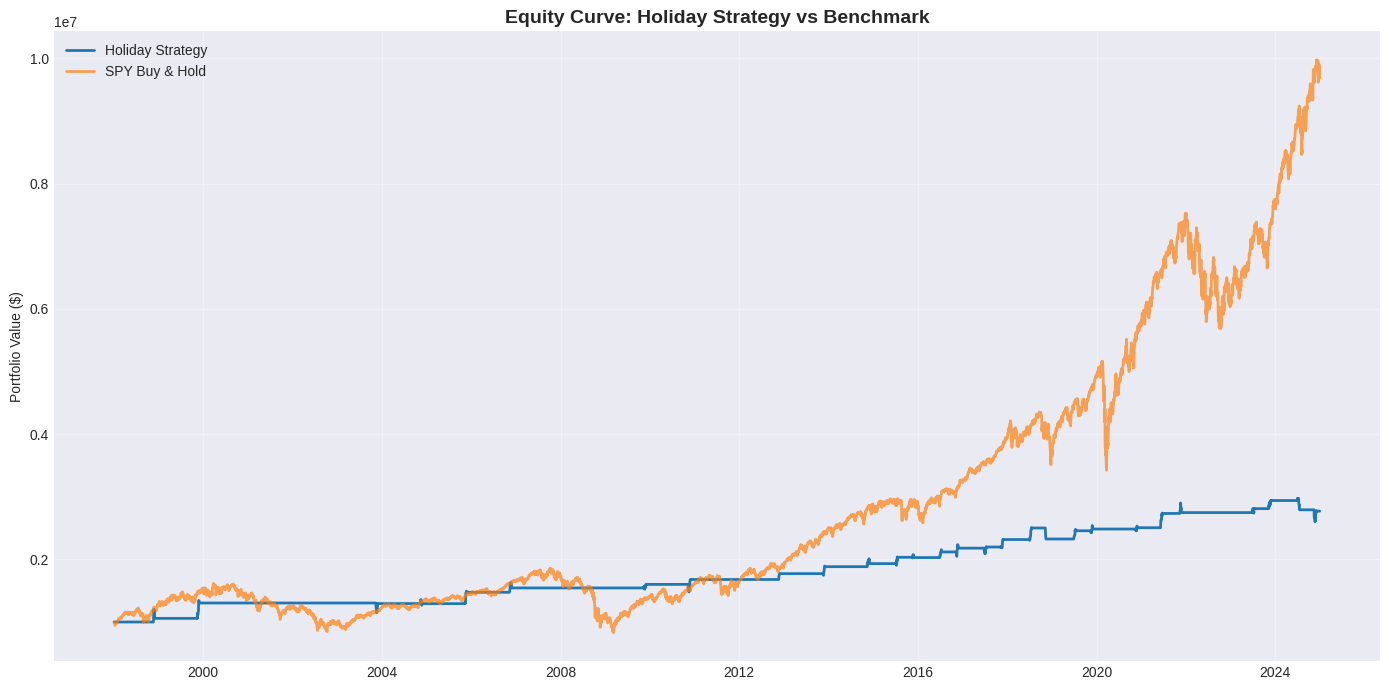

In [3]:
equity = results['portfolio']['portfolio_value']
benchmark = dataset['spy_prices']['Adj Close'].reindex(equity.index)
benchmark_normalized = benchmark / benchmark.iloc[0] * results['initial_capital']

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(equity.index, equity, label='Holiday Strategy', linewidth=2)
ax.plot(benchmark_normalized.index, benchmark_normalized, label='SPY Buy & Hold', linewidth=2, alpha=0.7)
ax.set_title('Equity Curve: Holiday Strategy vs Benchmark', fontsize=14, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Drawdown Analysis

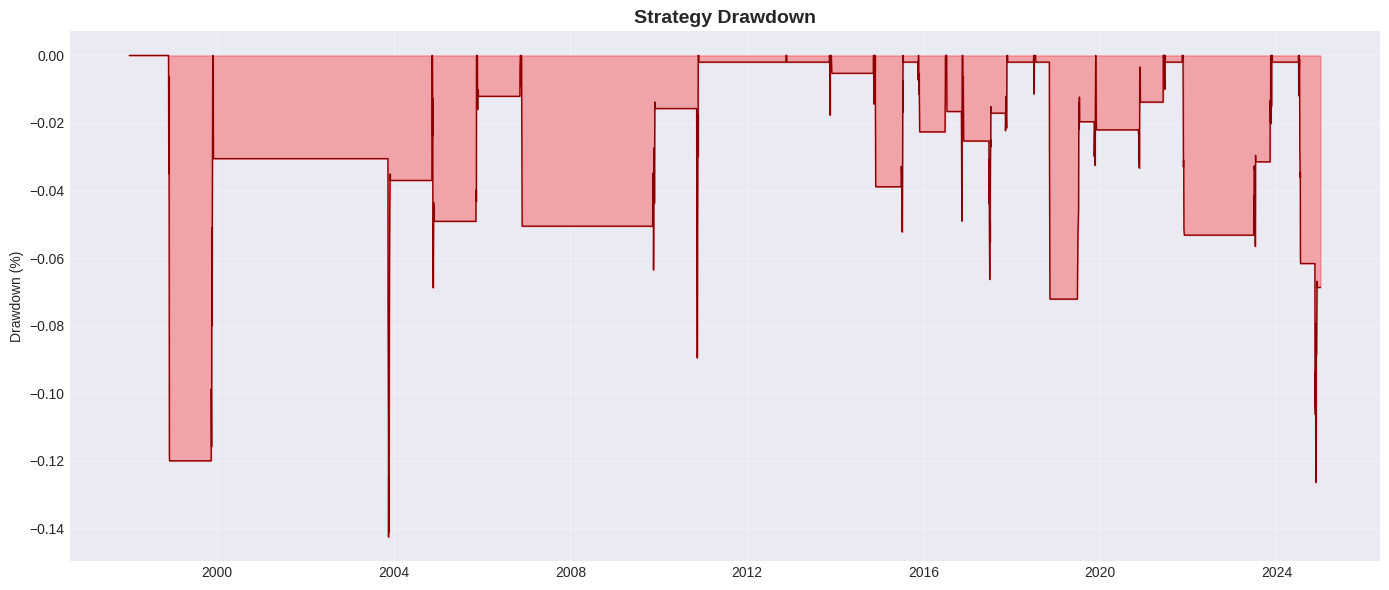

Max Drawdown: -14.26%
Average Drawdown: -3.10%


In [4]:
# Calculate drawdowns
running_max = equity.cummax()
drawdown = (equity - running_max) / running_max

fig, ax = plt.subplots(figsize=(14, 6))
ax.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
ax.plot(drawdown.index, drawdown, color='darkred', linewidth=1)
ax.set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")
print(f"Average Drawdown: {drawdown[drawdown < 0].mean():.2%}")

## 4. Monthly Returns Heatmap

/tmp/ipykernel_33980/2040871930.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = equity.resample('M').last().pct_change()


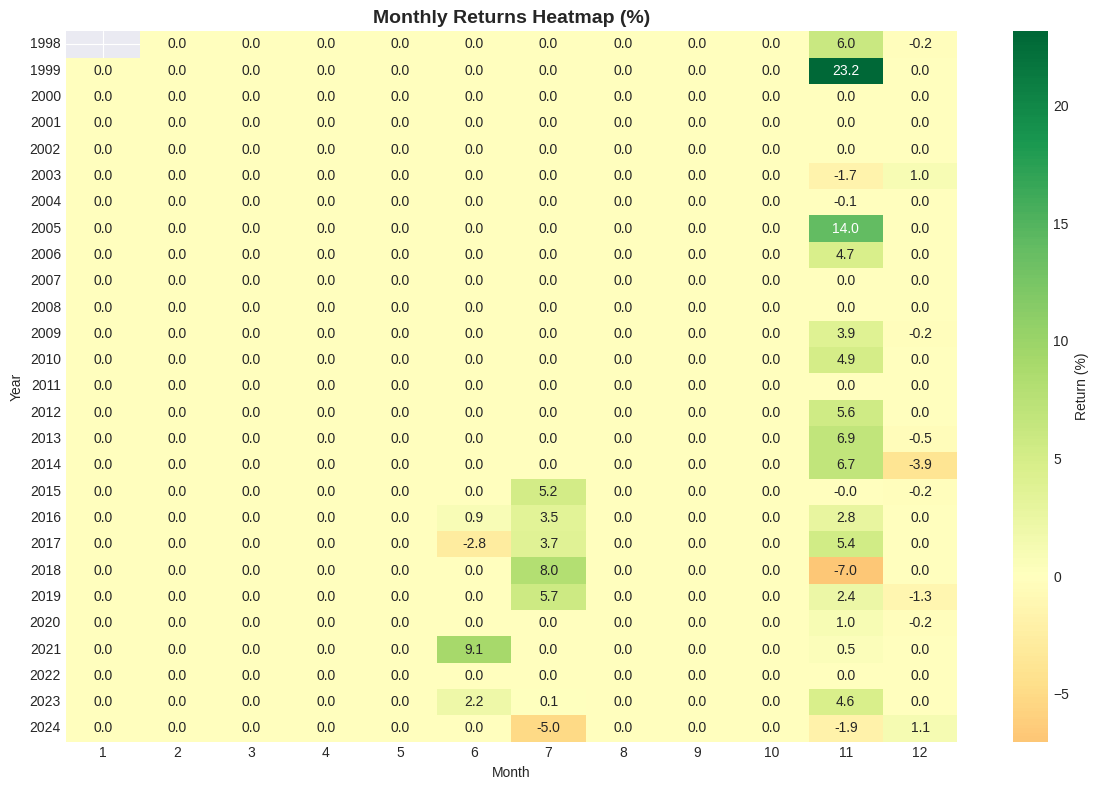

In [5]:
# Calculate monthly returns
monthly_returns = equity.resample('M').last().pct_change()
monthly_returns_pivot = monthly_returns.groupby(
    [monthly_returns.index.year, monthly_returns.index.month]
).first().unstack()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(monthly_returns_pivot * 100, annot=True, fmt='.1f', 
            cmap='RdYlGn', center=0, ax=ax, cbar_kws={'label': 'Return (%)'})
ax.set_title('Monthly Returns Heatmap (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Year')
ax.set_xlabel('Month')
plt.tight_layout()
plt.show()

## 5. Trade Analysis

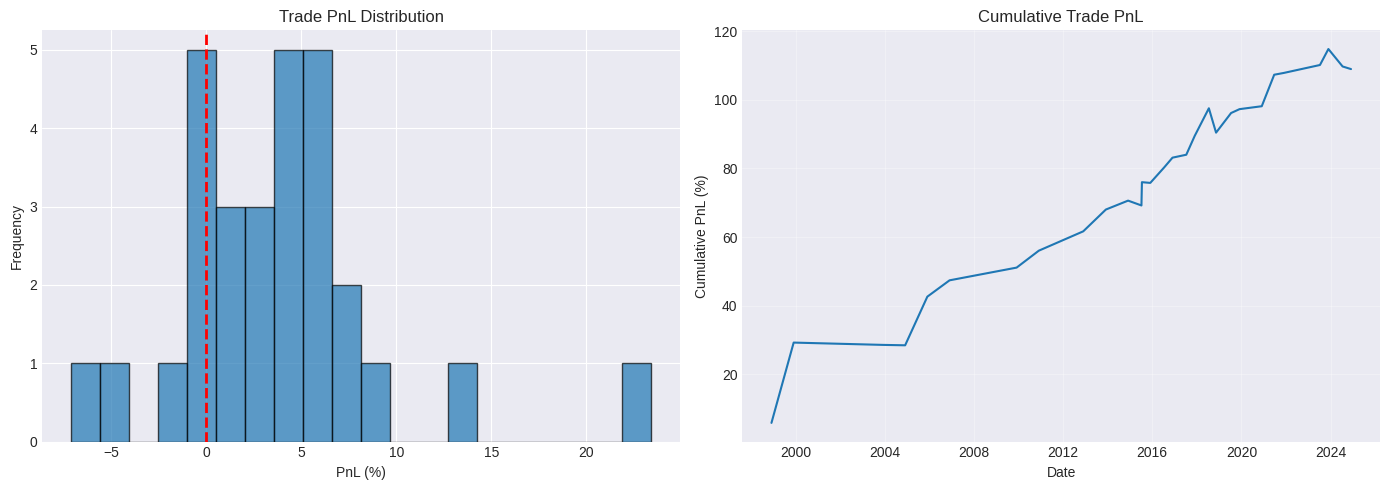

Average Trade PnL: 3.76%
Median Trade PnL: 3.71%
Best Trade: 23.39%
Worst Trade: -7.10%


In [6]:
trades = results['trades']

# Calculate PnL per trade
buy_trades = trades[trades['action'] == 'buy'].reset_index(drop=True)
sell_trades = trades[trades['action'] == 'sell'].reset_index(drop=True)

if len(buy_trades) > 0 and len(sell_trades) > 0:
    trade_pnl = []
    for i in range(min(len(buy_trades), len(sell_trades))):
        pnl = sell_trades.iloc[i]['value'] - buy_trades.iloc[i]['value']
        pnl_pct = pnl / buy_trades.iloc[i]['value'] * 100
        trade_pnl.append({
            'entry_date': buy_trades.iloc[i]['date'],
            'exit_date': sell_trades.iloc[i]['date'],
            'pnl': pnl,
            'pnl_pct': pnl_pct
        })
    
    trade_pnl_df = pd.DataFrame(trade_pnl)
    
    # Plot trade PnL distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(trade_pnl_df['pnl_pct'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Trade PnL Distribution')
    axes[0].set_xlabel('PnL (%)')
    axes[0].set_ylabel('Frequency')
    
    axes[1].plot(trade_pnl_df['exit_date'], trade_pnl_df['pnl_pct'].cumsum())
    axes[1].set_title('Cumulative Trade PnL')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Cumulative PnL (%)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average Trade PnL: {trade_pnl_df['pnl_pct'].mean():.2f}%")
    print(f"Median Trade PnL: {trade_pnl_df['pnl_pct'].median():.2f}%")
    print(f"Best Trade: {trade_pnl_df['pnl_pct'].max():.2f}%")
    print(f"Worst Trade: {trade_pnl_df['pnl_pct'].min():.2f}%")

## 6. Benchmark Comparison

In [7]:
comparison = backtester.compare_to_benchmark(results, dataset['spy_prices'])

print("=== Strategy vs Benchmark ===")
print(f"Strategy Return:       {comparison['strategy_total_return']:.2f}%")
print(f"Benchmark Return:      {comparison['benchmark_total_return']:.2f}%")
print(f"Excess Return:         {comparison['excess_return']:.2f}%")
print(f"Strategy Sharpe:       {comparison['strategy_sharpe']:.2f}")
print(f"Benchmark Sharpe:      {comparison['benchmark_sharpe']:.2f}")
print(f"Sharpe Improvement:    {comparison['sharpe_improvement']:.2f}")

=== Strategy vs Benchmark ===
Strategy Return:       177.05%
Benchmark Return:      868.57%
Excess Return:         -691.52%
Strategy Sharpe:       0.55
Benchmark Sharpe:      0.53
Sharpe Improvement:    0.02
